# Run ML algorithms

In [60]:
# Import Stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

from hpsklearn import HyperoptEstimator, svc, k_neighbors_classifier, logistic_regression, ada_boost_classifier, decision_tree_classifier



In [2]:
pheme = pd.read_csv('pheme.csv')
politifact = pd.read_csv('politifact.csv')


In [3]:
politifact.head()

,Unnamed: 0,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,0,True,Barack Obama,john mccain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...
1,1,False,Matt Gaetz,bennie thompson actively cheer led riots in t...,6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...
2,2,True,Kelly Ayotte,says maggie hassan was out of state on day...,5/18/2016,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...
3,3,False,Bloggers,busted cdc inflated covid numbers accused o...,2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...
4,4,True,Bobby Jindal,i am the only republican candidate that has...,8/30/2015,television,Linda Qiu,8/30/2015,https://www.politifact.com/factchecks/2015/aug...


In [3]:
# Prep data / Encode text

tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
#tfidf = HashingVectorizer(n_features=2**14)
#Fix this - encode the datasets together
all_statements = np.append(politifact['statement'].values, pheme['text'].values)
print(all_statements.shape)
all_tf = tfidf.fit_transform(all_statements)
polit_tf = all_tf[:21152]
pheme_tf = all_tf[21152:]

#polit_tf = tfidf.fit_transform(politifact['statement'].values)
#pheme_tf = tfidf.fit_transform(pheme['text'].values)

cv = CountVectorizer()
X_cv = cv.fit_transform(pheme['text'].values)

print(polit_tf.shape)
print(pheme_tf.shape)

(23554,)
(21152, 17894)
(2402, 17894)


In [4]:
# Select encoding
X = pheme_tf
#X = X_cv
y = pheme['target']

rs = 42

method = 0

if method == 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = rs)
else:
    X_test = pheme_tf
    y_test = pheme['target']
    X_train = polit_tf
    y_train = politifact['verdict']

# Set no. of folds
num_folds = 10

###Things to do: add more features

In [7]:
# Model running function
def run_model_after_gridsearch(best_estimators, X_train, y_train, X_test, y_test):
    mod = best_estimators
    mod.fit(X_train, y_train)
    pred_y = mod.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show()  

In [8]:
def run_model_manually(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

In [24]:
def optimize_model(model, X_train, y_train):
    mod = HyperoptEstimator(classifier=model,
                            preprocessing=[],
                            max_evals=50)
    mod.fit(X_train, y_train)
    print(mod.best_model())
    return mod

def evaluate_model(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 
    

In [28]:
# SVM
svm = optimize_model(svc("mySVC"), X_train, y_train)

100%|██████████| 50/50 [00:03<00:00,  3.92s/trial, best loss: 0.12188365650969524]
{'learner': SVC(C=0.9852876843464358, coef0=0.800700984120711, degree=4, random_state=4,
    shrinking=False, tol=0.00970440159075791), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 84.53 %
F1: 84.35 %


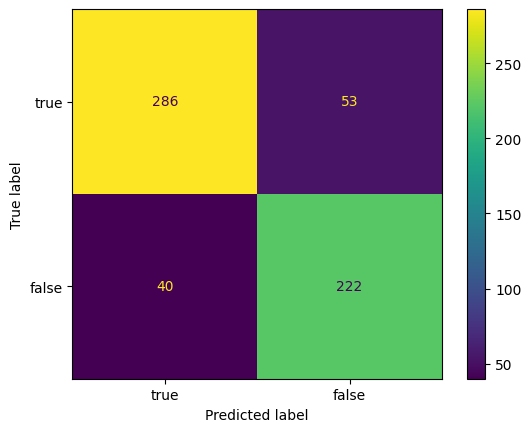

In [29]:
evaluate_model(svm, X_test, y_test)

In [53]:
# KNN
from sklearn.neighbors import VALID_METRICS_SPARSE
from hyperopt import hp
knn_metrics = hp.choice("metric", {'cityblock', 'l1', 'l2', 'euclidean', 'manhattan'})
knn= optimize_model(k_neighbors_classifier("myKNN", metric=knn_metrics), X_train, y_train)


100%|██████████| 50/50 [00:03<00:00,  3.84s/trial, best loss: 0.1412742382271468]
{'learner': KNeighborsClassifier(leaf_size=24, metric='euclidean', n_jobs=1, n_neighbors=1,
                     p=3.1714035251662933, weights='distance'), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 87.85 %
F1: 87.73 %


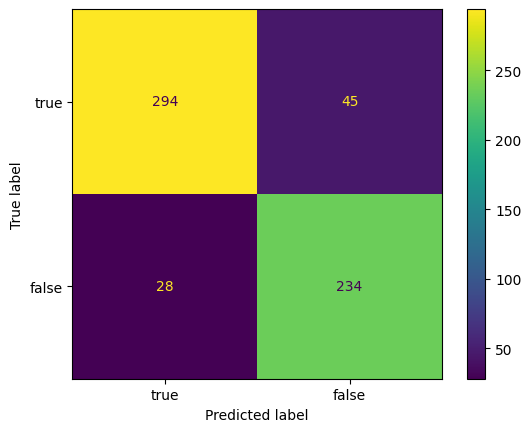

In [54]:
evaluate_model(knn, X_test, y_test)

In [57]:
# Logistic Regression logistic_regression
myLR = optimize_model(logistic_regression("myLR"), X_train, y_train)

100%|██████████| 50/50 [00:03<00:00,  3.20s/trial, best loss: 0.14404432132963985]
{'learner': LogisticRegression(C=1.5505403080866935, max_iter=270, n_jobs=1, random_state=0,
                   solver='liblinear', tol=0.0001487098203537736), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 84.19 %
F1: 84.01 %


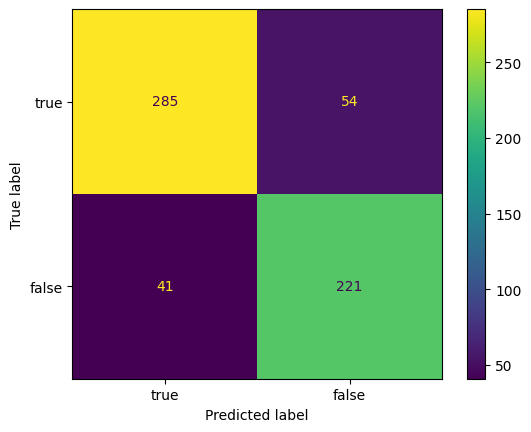

In [58]:
evaluate_model(myLR, X_test, y_test)

In [62]:
# AdaBoost
baseDT = decision_tree_classifier("adaDT")
ada = optimize_model(ada_boost_classifier("myada", estimator=baseDT), X_train, y_train)

 50%|█████     | 1/2 [00:04<?, ?trial/s, best loss=?]


c:\Users\willc\miniconda3\envs\rumour-ensemble\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 82.36 %
F1: 0.8227197845009906


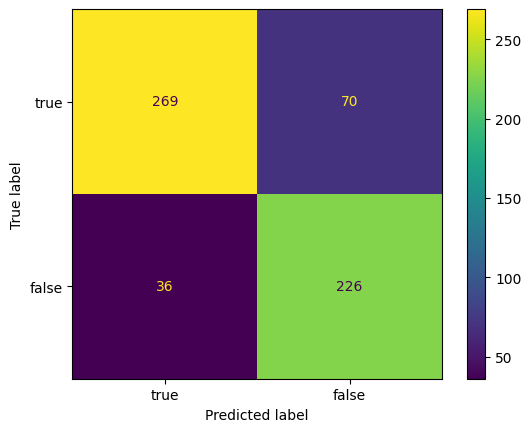

In [ ]:
# Run model with best results
evaluate_model(ada, X_test, y_test)